## Import thư viện

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from wordcloud import WordCloud
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')  # Download NLTK data (if not already downloaded)
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uyenb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uyenb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\uyenb\AppData\Roaming\nltk_data...


## Đọc file

In [7]:
survey_df = pd.read_csv('Data/survey.csv')
survey_df

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN


## Câu hỏi 1: Mức độ sẵn sàng thảo luận các vấn đề sức khỏe tâm thần của người trả lời với người giám sát và đồng nghiệp của họ như thế nào và điều này thay đổi như thế nào tùy theo quy mô của công ty và Quốc gia?

**Mục tiêu:** Giúp chúng ta hiểu về sự sẵn sàng chung của nhân viên để thảo luận các vấn đề sức khỏe tâm thần của họ. Và liên quan tới quy mô, thông tin này có thể có giá trị để các tổ chức đánh giá các chính sách sức khỏe tâm thần của họ và tạo môi trường hỗ trợ cho nhân viên của họ. Nó cũng có thể cung cấp thông tin cho các sáng kiến nhằm giảm bớt sự kỳ thị liên quan đến việc thảo luận về sức khỏe tâm thần tại nơi làm việc.

Để trả lời câu hỏi này, ta sẽ sử dụng các cột `coworkers`, `supervisor`, `Country` và `no_employees`.

Các công việc cụ thể:
- Nhóm người trả lời theo quy mô công ty.
- So sánh tỷ lệ sẵn sàng thảo luận các vấn đề sức khỏe tâm thần trong cột `supervisor` và cột `coworkers`.

## Preprocessing

Xem thông tin của các cột `coworkers`, `supervisor`, `Country` và `no_employees`.

In [54]:
survey_df[['coworkers','supervisor','Country','no_employees']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   coworkers     1259 non-null   object
 1   supervisor    1259 non-null   object
 2   Country       1259 non-null   object
 3   no_employees  1259 non-null   object
dtypes: object(4)
memory usage: 39.5+ KB


Không có missing values, cũng không có bất thường ở kiểu dữ liệu.

## EDA

Tạo hai DataFrame `supervisor_df` và `coworkers_df` lưu từng nhóm người trả lời theo quy mô công ty với ba nhóm: Yes, No và Some of them.

In [55]:
# Create a new DataFrame by grouping 'no_employees'
supervisor_df = survey_df.groupby(['no_employees','supervisor']).size().unstack()

coworkers_df = survey_df.groupby(['no_employees','coworkers']).size().unstack()

# Specify the new order of the columns
new_order = ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']

# Reorder the columns
supervisor_df = supervisor_df.reindex(new_order, axis=0)
coworkers_df = coworkers_df.reindex(new_order, axis=0)

#supervisor_df
coworkers_df

coworkers,No,Some of them,Yes
no_employees,,,
1-5,30,92,40
6-25,52,176,62
26-100,52,184,53
100-500,30,117,29
500-1000,14,39,7
More than 1000,82,166,34


Để thể hiện rõ sự so sánh giữa quy mô công ty, ta sẽ chuyển các cột giá trị `No`, `Some of them` và `Yes` của hai DataFrame này thành dạng `%`.

In [59]:
# Calculate the sum of each row
def row_sum(df):
    row_sum = df.sum(axis=1)
    return row_sum

# Divide each value in the DataFrame by the sum of its row and multiply by 100
percent_supervisor_df = supervisor_df.div(row_sum(supervisor_df), axis=0) * 100
percent_coworkers_df = coworkers_df.div(row_sum(coworkers_df), axis=0) * 100

#percent_supervisor_df
percent_coworkers_df

coworkers,No,Some of them,Yes
no_employees,,,
1-5,18.518519,56.790123,24.691358
6-25,17.931034,60.689655,21.379310
26-100,17.993080,63.667820,18.339100
100-500,17.045455,66.477273,16.477273
500-1000,23.333333,65.000000,11.666667
More than 1000,29.078014,58.865248,12.056738


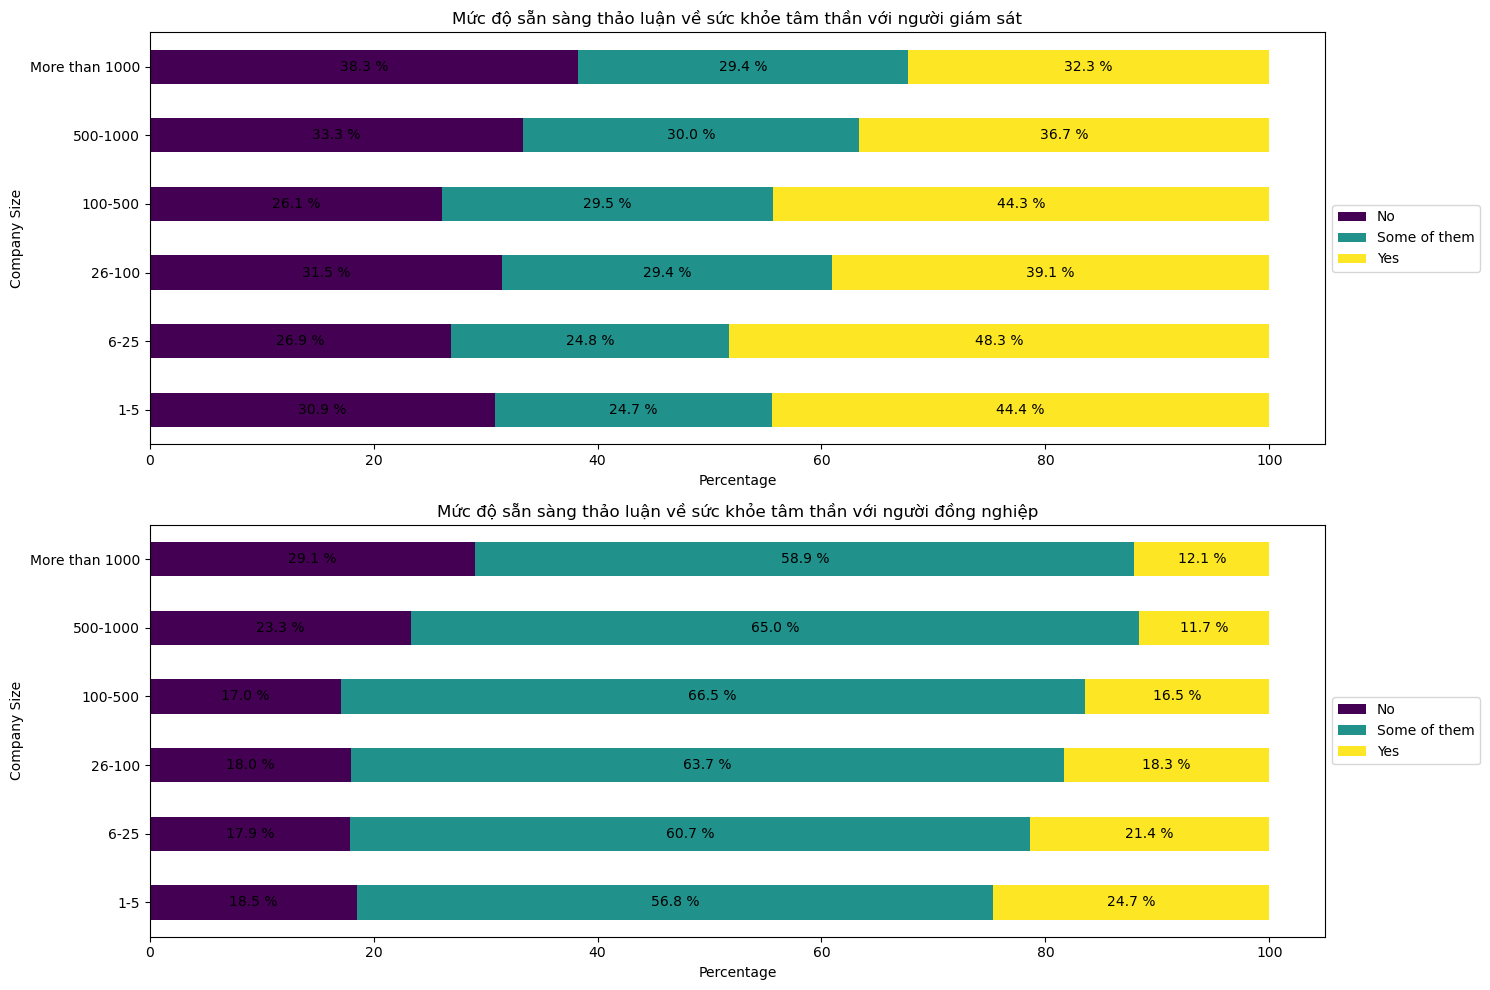

In [85]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

def barh_plot(df, ax, title):
    df.plot(kind='barh', stacked=True, colormap='viridis', ax=ax)

    # Add values into the columns
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.1f} %'.format(width), 
                horizontalalignment='center', 
                verticalalignment='center')

    ax.set_title(title)
    ax.set_ylabel('Company Size')
    ax.set_xlabel('Percentage')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


barh_plot(percent_supervisor_df, axs[0], "Mức độ sẵn sàng thảo luận về sức khỏe tâm thần với người giám sát")
barh_plot(percent_coworkers_df, axs[1], "Mức độ sẵn sàng thảo luận về sức khỏe tâm thần với người đồng nghiệp")

plt.tight_layout()
plt.show()

### Nhận xét:

Ở biểu đồ **Mức độ sẵn sàng thảo luận về sức khỏe tâm thần với người giám sát**:
- Số người trả lời **Some of them** ít hơn 2 phần còn lại, lí giải điều này có thể do ở một số công ty, người giám sát chỉ có 1 hoặc vài người nên người trả lời coi như không có lựa chọn này.
- Nhìn chung số người trả lời **Yes** giảm dần so với quy mô công ty ngày càng tăng, và tương tự số người trả lời **No** thì lại tăng dần. 
    - Điều này cho ta thấy trong các công ty nhỏ và vừa, mối quan hệ giữa nhân viên và người giám sát có thể gần gũi hơn, do đó có thể dễ dàng thảo luận về vấn đề sức khỏe tâm thần hơn. 
    - Tuy nhiên, trong các công ty lớn, việc thảo luận về vấn đề này có thể trở nên khó khăn hơn do sự tách biệt giữa các cấp quản lý.

Ở biểu đồ **Mức độ sẵn sàng thảo luận về sức khỏe tâm thần với đồng nghiệp**:
- Số người trả lời **Some of them** nhiều hơn 2 phần còn lại, do có thể đồng nghiệp chỉ phần chung toàn bộ công ty, nên câu trả lời này cũng có thể được tính là **Yes**.
- Cũng như biểu đồ trên, số người trả lời **Yes** giảm dần so với quy mô công ty ngày càng tăng, và tương tự số người trả lời **No** thì lại tăng dần. 
    - Giải thích tương tự như trên, với các công ty vừa và nhỏ, đồng nghiệp gần gũi nên có thể dễ dàng tương tác, thảo luận về vấn đề sức khỏe tâm thần hơn các công ty lớn.

Nếu ta coi **Some of them** đồng nghĩa với **Yes**, thì với 2 đối tượng `Người giám sát` và `Đồng nghiệp` người ta có xu hướng thảo luận thoải mái với đồng nghiệp hơn. Đây cũng là tâm lí chung của mọi người

Tuy nhiên, điều quan trọng là mọi người cần được khuyến khích và hỗ trợ để thảo luận về sức khỏe tâm thần của họ một cách an toàn và không bị đánh đồng. Điều này không chỉ giúp cải thiện sức khỏe tâm thần của nhân viên, mà còn tạo ra một môi trường làm việc tích cực và hiệu quả.

## Câu 2: Phân tích quan điểm, cách nhìn nhận vấn đề sức khỏe tâm thần nơi làm việc của nhân viên

**Mục tiêu:** Phân loại cách các nhân viên suy nghĩ đối với vấn đề sức khỏe tâm thần nơi làm việc của họ theo 3 loại: Tích cực(Positive), Tiêu cực(Negative) và Trung tính(Neutral).

Để trả lời câu hỏi này, ta sẽ sử dụng các cột

Các công việc cụ thể:

### Bước 1: Chọn từ tập dữ liệu các dòng cần thiết (các dòng khác NaN)
Lưu vào DataFrame `cmt_df`

In [55]:
cmt_df = survey_df[survey_df['comments'].notna()]
cmt_df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
13,2014-08-27 11:33:26,36,Male,United States,CT,NaN,Yes,No,Never,500-1000,...,Don't know,No,No,Yes,Yes,No,No,Don't know,No,I'm not on my company's health insurance which...
15,2014-08-27 11:34:00,29,female,United States,IL,NaN,Yes,Yes,Rarely,26-100,...,Somewhat easy,No,No,Yes,Some of them,Maybe,Maybe,Don't know,No,I have chronic low-level neurological issues t...
16,2014-08-27 11:34:20,23,Male,United Kingdom,NaN,NaN,No,Yes,Sometimes,26-100,...,Very easy,Maybe,No,Some of them,No,Maybe,Maybe,No,No,My company does provide healthcare but not to ...
24,2014-08-27 11:36:48,33,male,United States,CA,No,Yes,Yes,Rarely,26-100,...,Don't know,No,No,Yes,Yes,No,Yes,Don't know,No,Relatively new job. Ask again later
25,2014-08-27 11:37:08,35,male,United States,TN,No,Yes,Yes,Sometimes,More than 1000,...,Very easy,Yes,No,Some of them,Yes,No,Yes,No,No,Sometimes I think about using drugs for my me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,2015-02-21 11:55:46,23,Male,United Kingdom,NaN,No,No,No,Never,26-100,...,Somewhat easy,Maybe,No,Some of them,Some of them,No,Maybe,Yes,Yes,Although my employer does everything they can ...
1232,2015-02-24 09:00:56,25,Male,United Kingdom,NaN,No,Yes,Yes,Sometimes,More than 1000,...,Very easy,No,No,Yes,Yes,Yes,Yes,Yes,No,I work at a large university with a track reco...
1234,2015-02-24 09:15:13,24,"ostensibly male, unsure what that really means",United Kingdom,NaN,No,No,Yes,Sometimes,6-25,...,Don't know,Yes,Maybe,No,No,No,Maybe,Don't know,No,i'm in a country with social health care so my...
1245,2015-05-06 10:14:50,22,Male,Australia,NaN,No,Yes,Yes,Often,100-500,...,Don't know,Maybe,Maybe,No,Yes,No,Maybe,Don't know,Yes,In australia all organisations of a certain si...


### Bước 2: Tiền xử lí các dữ liệu văn bản
Xây dựng một hàm:
- Chuyển các chữ cái in hoa thành chữ cái thường
- Loại bỏ kí tự đặc biệt như ! ? . ,
- Loại bỏ stopwords

Stopwords trong tiếng Anh thường bao gồm các từ phổ biến mang ít ý nghĩa ngữ nghĩa và thường bị loại trừ trong quá trình phân tích văn bản. Ví dụ như "the", "and", "is", "in", "this",...

Sử dụng thư viện có sẵn, ta định nghĩa một danh sách stopwords dưới đây

In [62]:
# Tokenize stopwords
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Định nghĩa hàm `preprocess_comments` và áp dụng cho tất cả các dòng dữ liệu

In [66]:
def preprocess_comments(text):
    try:
        # Tokenize the text
        words = word_tokenize(text)
        # Lowercase the words
        words = [word.lower() for word in words]
        # Remove punctuation from words
        words = [word.translate(str.maketrans('','',string.punctuation)) for word in words]
        # Filter out stopwords 
        filtered_words = [word for word in words if word not in stop_words]
        # Join the filtered words back into a string
        return ' '.join(filtered_words)
    except:
        # Handle exceptions by returning an empty string
        return ''

# Apply the preprocessing function to the 'comments' column
cmt_df['comments'] = cmt_df['comments'].apply(preprocess_comments)
cmt_df[['comments']]

13      company health insurance could part reason ans...
15      chronic lowlevel neurological issues mental he...
16      company provide healthcare fixedterm contract ...
24                           relatively new job ask later
25      sometimes think using drugs mental health issu...
                              ...                        
1223    although employer everything accommodate emplo...
1232    work large university track record health well...
1234    country social health care options dependant e...
1245    australia organisations certain size provide f...
1249                                     bipolar disorder
Name: comments, Length: 164, dtype: object

### Bước 3: Sentiment Analysis
Tính toán sentiment scores - kết quả phân tích chỉ số cảm xúc của các thảo luận để xác định tương quan giữa các thảo luận.

Kết quả trả về là một Series: score và 4 phân lớp - nagetive, positive, neutral và compound

In [68]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores
cmt_df['Sentiment'] = cmt_df['comments'].apply(lambda x: analyzer.polarity_scores(x))

# Extract the compound sentiment score (ranges from -1 to 1, where -1 is negative, 0 is neutral, and 1 is positive)
cmt_df['Sentiment'] = cmt_df['Sentiment'].apply(lambda x: x['compound'])

In [69]:
cmt_df[['Sentiment']]

13      0.0000
15      0.1531
16      0.0000
24      0.0000
25      0.4404
         ...  
1223   -0.6597
1232    0.4019
1234    0.4939
1245    0.6597
1249   -0.4019
Name: Sentiment, Length: 164, dtype: float64

Vẽ histogram để thể hiện phân bố của từng khoảng điểm

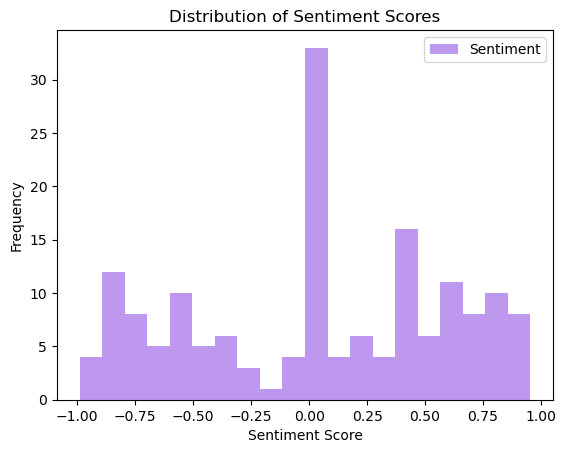

In [72]:
# Create a histogram of sentiment scores
plt.hist(cmt_df['Sentiment'], bins=20, alpha=0.5, color='#7E30E1', label='Sentiment')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.legend(loc='best')
plt.show()

**Nhận xét:**
- Khoảng điểm 0.0 là cao nhất, cho thấy nhìn nhận vấn đề sức khỏe tâm thần của nhân viên ở mức trung lập, bình thường.
- Ở hai miền phân bố điểm trái, phải cũng có vài khoảng điểm có tần suất xuất hiện nhiều và gần bằng nhau.
- Nhưng khoảng điểm -1.0 cho thấy có những nhân viên có suy nghĩ rất tiêu cực về tình trạng sức khỏe tâm thần, còn ở khoảng 1.0 thì không có.

#### Ta sẽ đưa các con số về 3 phân loại cho các range điểm:
- Positive nếu score > 0.5
- Negative nếu score < -0.5
- Neutral cho các trường hợp giữa -0.5 và 0.5

In [73]:
# Define function
def category(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply to the 'Sentiment' column
cmt_df['Sentiment_Label'] = cmt_df['Sentiment'].apply(category)

In [75]:
cmt_df[['Sentiment_Label']]

,Sentiment_Label
13,Neutral
15,Positive
16,Neutral
24,Neutral
25,Positive
...,...
1223,Negative
1232,Positive
1234,Positive
1245,Positive


Vẽ biểu đồ tròn thể hiện phân bố % của các phân loại so với tổng thể

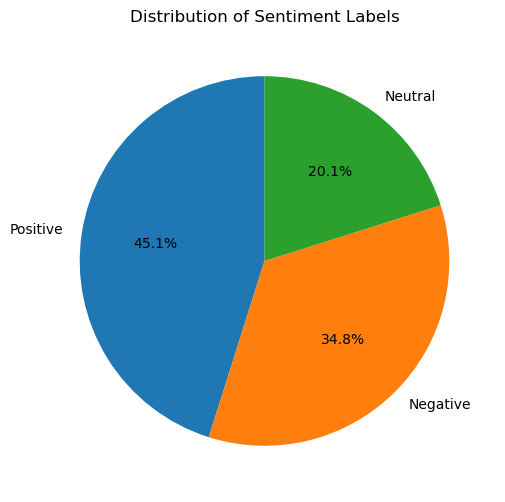

In [82]:
# Count values
sentiment_counts = cmt_df['Sentiment_Label'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)

# Add labels and title
plt.title("Distribution of Sentiment Labels")

# Show the plot
plt.show()

**Nhận xét:**
- Như ta đã thấy ở đồ thị histogram có khoảng điểm 0.0 là cao nhất, tuy nhiên số lượng phản hồi Neutral chỉ chiếm 20%. Lí giải cho điều này là bởi các lận cận của khoảng điểm 0.0 ở đồ thị histogram rất thấp mặc dù ở chính giữa rất cao. Còn các khoảng khác không cao nhất, tuy nhiên chúng phân bố đều, như ở cả hai phản hồi Positive và Negative.


In [79]:
cmt_df = cmt_df[['comments','Sentiment_Label']]
cmt_df.head(30)

,comments,Sentiment_Label
13,company health insurance could part reason ans...,Neutral
15,chronic lowlevel neurological issues mental he...,Positive
16,company provide healthcare fixedterm contract ...,Neutral
24,relatively new job ask later,Neutral
25,sometimes think using drugs mental health issu...,Positive
33,selected current employer based policies self ...,Positive
45,health plan covered psychotherapy antidepressa...,Negative
49,started new job last week hence lot nt know,Neutral
59,addition mental health issues known several co...,Neutral
66,thanks research,Positive
